**Laboratorio N°2 - SIS420**

**Introducción.**

En este cuadernillo de Python, abordaremos el proceso de entrenamiento y evaluación de modelos de regresión logística utilizando un dataset específico. El objetivo principal es comprender y aplicar diferentes técnicas de regresión logística, incluyendo la regresión logística binaria y multinomial. Utilizaremos un conjunto de datos que cumpla con ciertos criterios establecidos, incluyendo variables independientes y una variable dependiente categórica.

**Objetivos.**

- Seleccionar un dataset adecuado que cumpla con los requisitos de tamaño y características necesarias.
- Implementar modelos de regresión logística binaria en Python.
- Entrenar y validar cada modelo utilizando técnicas adecuadas de división de datos y validación cruzada.
- Evaluar la efectividad de cada modelo mediante la realización de predicciones.
- Utilizar la biblioteca Pandas para procesar y manipular los datos del dataset.
- Generar un gráfico de costo para ver qué ocurre al entrenar el moodelo.


In [95]:
print(f"Laboratorio N°2 - SIS420: Gabriel Aparicio Llanquipacha.")
print(f"Carrera: Ingeniería en Ciencias de la Computación.")

Laboratorio N°2 - SIS420: Gabriel Aparicio Llanquipacha.
Carrera: Ingeniería en Ciencias de la Computación.


**(0) Montar Google Drive en Colaboratoy.** Una vez que el Google Drive está montado, puedes acceder a los archivos almacenados en tu Google Drive directamente desde el entorno de Colaboratory.

In [96]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


**(1) Establecimiento de las Librerías.** Iremos cargando y asignando nombres a las librerías que vayamos a usar durante todo este texto, de forma que nos sea fácil realizar el entrenamiento. Las librerías como numpy, pandas, matplotlib, scipy, y sklearn proporcionan las herramientas fundamentales para el manejo de datos, cálculos matemáticos, visualización gráfica, y métodos de aprendizaje automático. Importar estas librerías al principio del código asegura que todas las funciones necesarias estén disponibles para su uso en las etapas subsiguientes.

In [97]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy import optimize
import shutil
from sklearn.model_selection import train_test_split
%matplotlib inline

**(a) Creación de las funciones.** Se crean las funciones para que el código sea más legible e interpretable, además de que con este enfoque modular el código se presentará más limpio y se enfocará más en el algoritmo como tal, aquí se irán agregando las siguientes funciones:

*(i) Graficar Datos.* Esta función se utiliza para graficar los datos de entrada X junto con sus respectivas etiquetas y. Los puntos se representan en una gráfica, donde los puntos correspondientes a la clase positiva se marcan con un * y los de la clase negativa se marcan con un o.

In [98]:
def graficarDatos(X, y):
    fig = plt.figure()
    pos = y == 1
    neg = y == 0
    plt.plot(X[pos, 0], X[pos, 1], 'k*', lw=2, ms=10)
    plt.plot(X[neg, 0], X[neg, 1], 'ko', mfc='y', ms=8, mec='k', mew=1)
    plt.xlabel('X')
    plt.ylabel('Label')
    plt.legend(['Cambio', 'No Cambio'])

*(ii) Sigmoide.* Esta función calcula la función sigmoide para una entrada z. La función sigmoide es comúnmente utilizada en regresión logística para comprimir el rango de valores a un intervalo entre 0 y 1, lo que facilita la interpretación como una probabilidad.

In [99]:
def sigmoide(z):
    z = np.array(z)
    g = np.zeros(z.shape)
    g = 1 / (1 + np.exp(-z))
    return g

*(iii) Calcular Costo.* Esta función calcula la función de costo de la regresión logística, dada la matriz de características X, las etiquetas y y los parámetros del modelo theta. La función de costo mide la discrepancia entre las predicciones del modelo y las etiquetas reales.

In [100]:
def calcularCosto(theta, X, y):
    m = y.size
    J = 0
    h = sigmoide(X.dot(theta.T))
    J = (1 / m) * np.sum(-y.dot(np.log(h)) - (1 - y).dot(np.log(1 - h)))
    return J

*(iv) Descenso por el Gradiente.* Esta función implementa el algoritmo de descenso por el gradiente para encontrar los parámetros óptimos del modelo de regresión logística. Se actualiza iterativamente los parámetros theta en la dirección que minimiza la función de costo, utilizando un tamaño de paso alpha durante un número num_iters de iteraciones.

In [101]:
def descensoGradiente(theta, X, y, alpha, num_iters):
    m = y.shape[0]
    theta = theta.copy()
    J_history = []
    for i in range(num_iters):
        h = sigmoide(X.dot(theta.T))
        theta = theta - (alpha / m) * (h - y).dot(X)
        J_history.append(calcularCosto(theta, X, y))
    return theta, J_history

*(v) Función de Costo.* Esta función calcula la función de costo y el gradiente de la función de costo para la regresión logística, dada la matriz de características X, las etiquetas y y los parámetros del modelo theta. Además de calcular el costo, también calcula el gradiente de la función de costo con respecto a los parámetros theta.

In [102]:
def funcionCosto(theta, X, y):
    m = y.size
    J = 0
    grad = np.zeros(theta.shape)
    h = sigmoide(X.dot(theta.T))
    J = (1 / m) * np.sum(-y.dot(np.log(h)) - (1 - y).dot(np.log(1 - h)))
    grad = (1 / m) * (h - y).dot(X)
    return J, grad

*(vi) Graficar el Límite de Decisión.* Esta función grafica los datos X junto con sus etiquetas y, y superpone el límite de decisión del modelo de regresión logística definido por los parámetros theta. Si el número de características es menor o igual a 3, traza una línea de decisión. Si hay más de 3 características, utiliza contornos para mostrar el límite de decisión.

In [103]:
def graficarLimiteDecision(graficarDatos, theta, X, y):
    X = normalizarCaracteristicas(X)
    graficarDatos(X[:, 1:9], y)
    if X.shape[1] <= 3:
        plot_x = np.array([np.min(X[:, 1]) - 2, np.max(X[:, 1]) + 2])
        plot_y = (-1. / theta[2]) * (theta[1] * plot_x + theta[0])
        plt.plot(plot_x, plot_y)
        plt.legend(['Cambio', 'No Cambio', 'Límite de decisión'])
        plt.xlim([np.min(X[:, 1]) - 2, np.max(X[:, 1]) + 2])
        plt.ylim([np.min(X[:, 2]) - 2, np.max(X[:, 2]) + 2])
    else:
        u = np.linspace(-2, 2, 50)
        v = np.linspace(-2, 2, 50)
        z = np.zeros((len(u), len(v)))
        for i, ui in enumerate(u):
            for j, vj in enumerate(v):
                features = np.ones((1, X.shape[1]))
                features[0, 1] = ui
                features[0, 2] = vj
                z[i, j] = np.dot(features.flatten(), theta.flatten())
        z = z.T
        levels = np.unique(np.sort([np.min(z), 0, np.max(z)]))
        if len(levels) > 1:
            plt.contour(u, v, z, levels=levels, linewidths=2, colors='g')
            plt.contourf(u, v, z, levels=levels, cmap='Greens', alpha=0.4)
        else:
            levels = np.linspace(np.min(z), np.max(z), 3)
            plt.contour(u, v, z, levels=levels, linewidths=2, colors='g')
            plt.contourf(u, v, z, levels=levels, cmap='Greens', alpha=0.4)
    plt.show()

*(vii) Normalizar Características.* La normalización asegura que todas las características tengan la misma escala, lo que es importante porque muchas técnicas de aprendizaje automático son sensibles a la escala de los datos. Al tener todas las características en una escala similar, se facilita y acelera el proceso de convergencia durante el entrenamiento del modelo. Esto es especialmente cierto para métodos basados en gradiente, donde la normalización puede prevenir problemas de estabilidad numérica y mejorar la eficiencia computacional.

In [104]:
def normalizarCaracteristicas(X):
    media = np.mean(X, axis=0)
    desviacion_estandar = np.std(X, axis=0)
    desviacion_estandar[desviacion_estandar == 0] = 1
    X_norm = (X - media) / desviacion_estandar
    return X_norm

*(viii) Predecir.* Esta función se utiliza para predecir las etiquetas de clase (0 o 1) para los datos de entrada X, utilizando los parámetros del modelo theta. Calcula las predicciones utilizando la función sigmoide y luego redondea los valores obtenidos para asignar las etiquetas finales.

In [105]:
def predecir(theta, X, umbral=0.5):
    probabilidad = sigmoide(np.dot(X, theta))
    print(probabilidad)
    predicciones = (probabilidad >= umbral).astype(int)
    return predicciones

**(2) Regresión Logística.**
La regresión logística es un algoritmo de aprendizaje supervisado utilizado para la clasificación binaria. A pesar de su nombre, la regresión logística se utiliza comúnmente para problemas de clasificación en lugar de problemas de regresión.

**(a) Cargar el Dataset y Manipular los Datos.** Cargaremos el dataset para poderlo procesar con pandas. *Una* vez cargados los datos, pandas proporciona herramientas poderosas para manipular y transformar los datos. Esto incluye la capacidad de seleccionar, filtrar, agrupar, fusionar y limpiar los datos de manera eficiente, lo que facilita la preparación de los datos para su análisis o modelado.

In [106]:
dataset = pd.read_csv('/content/gdrive/MyDrive/SIS420/Laboratorio-N2_-_SIS420/Dataset/Forex Data Sell Strategy/Forex Data Sell Strategy.csv')
dataset.drop('Datetime', axis=1, inplace=True)
train_set, test_set = train_test_split(dataset, test_size=0.2, random_state=9)
X_train, y_train = train_set.iloc[:, :-1], train_set.iloc[:, -1]
X_test, y_test = test_set.iloc[:, :-1], test_set.iloc[:, -1]
X_train = np.concatenate([np.ones((X_train.shape[0], 1)), X_train], axis=1)
X_test = np.concatenate([np.ones((X_test.shape[0], 1)), X_test], axis=1)
print(X_train)
print(y_train)
print(X_test)
print(y_test)

[[ 1.00000000e+00  1.17924535e+00  1.17924535e+00 ...  2.78115273e-04
   2.78115273e-04  1.38998032e-04]
 [ 1.00000000e+00  1.18553638e+00  1.18553638e+00 ... -5.61952591e-04
  -7.02261925e-04 -9.82999802e-04]
 [ 1.00000000e+00  1.18147445e+00  1.18147445e+00 ...  1.39594078e-04
   5.58614731e-04  1.39594078e-04]
 ...
 [ 1.00000000e+00  1.17647052e+00  1.17647052e+00 ...  2.76923180e-04
   4.15444374e-04  4.15444374e-04]
 [ 1.00000000e+00  1.18035889e+00  1.18035889e+00 ... -4.17947769e-04
  -4.17947769e-04 -2.78711319e-04]
 [ 1.00000000e+00  1.18147445e+00  1.18147445e+00 ... -6.97493553e-04
  -6.97493553e-04 -6.97493553e-04]]
21533    0
2754     0
15761    0
16302    1
18077    0
        ..
22584    0
501      0
23166    1
20828    0
24958    0
Name: label, Length: 21980, dtype: int64
[[ 1.00000000e+00  1.18091631e+00  1.18091631e+00 ...  4.18663025e-04
   5.58137894e-04  8.37445259e-04]
 [ 1.00000000e+00  1.17688596e+00  1.17688596e+00 ... -1.38521194e-04
  -1.38521194e-04  1.385211

**(b) Función de Costo y Gradiente.** La función de costo, o función de pérdida, mide qué tan bien el modelo está realizando sus predicciones comparado con los valores reales. En el contexto de la regresión logística, se utiliza para evaluar la diferencia entre las salidas predichas y los valores verdaderos. El objetivo durante el entrenamiento es minimizar esta función de costo, lo que indica que el modelo está haciendo predicciones más precisas. El gradiente es un vector que contiene todas las derivadas parciales de la función de costo con respecto a cada parámetro del modelo. En el aprendizaje automático, se utiliza para realizar el descenso de gradiente, un método de optimización que ajusta los parámetros del modelo para minimizar la función de costo. El gradiente indica la dirección en la que se debe ajustar cada parámetro para lograr la mayor disminución posible en la función de costo.

Theta calculado por el descenso por el gradiente: [-1.43919194e-01 -1.68650599e-01 -1.68650599e-01 -1.68650599e-01
 -1.68650599e-01 -1.68650599e-01  0.00000000e+00  1.21644671e-03
  8.22935575e-06 -1.05210507e-04 -9.24936758e-05 -1.00244645e-04
 -1.03597873e-04 -1.21091289e-04 -1.50049966e-04 -1.77110673e-04
 -1.59121781e-04 -1.57212618e-04 -1.29641677e-04 -1.10234251e-04
 -1.27204689e-04 -1.33731108e-04 -1.47726967e-04 -1.42332775e-04]
Último valor de la función de costo: 0.5660793788115183


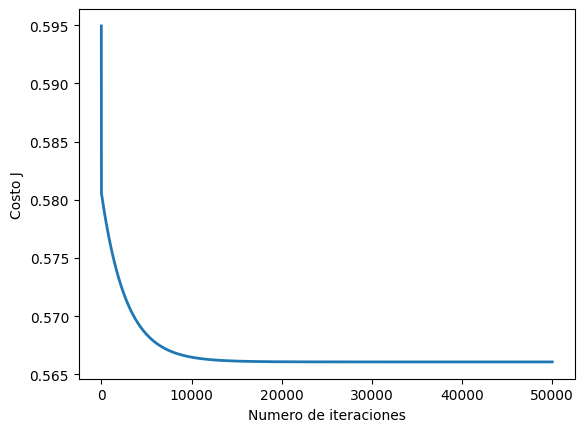

In [107]:
alpha = 0.001
num_iters = 50000
theta = np.zeros(X_train.shape[1])
theta, J_history = descensoGradiente(theta, X_train, y_train, alpha, num_iters)
plt.plot(np.arange(len(J_history)), J_history, lw=2)
plt.xlabel('Numero de iteraciones')
plt.ylabel('Costo J')
print('Theta calculado por el descenso por el gradiente:', theta)
print('Último valor de la función de costo:', J_history[-1])

**(c) Graficar Límites de Decisión** Los niveles de decisión se grafican para visualizar cómo el modelo de regresión logística ha aprendido a separar las clases. En un gráfico bidimensional, esta línea o curva representa el umbral donde el modelo cambia su predicción de una clase a otra. Es una herramienta poderosa para entender intuitivamente el comportamiento del modelo y cómo diferentes características influyen en la predicción.

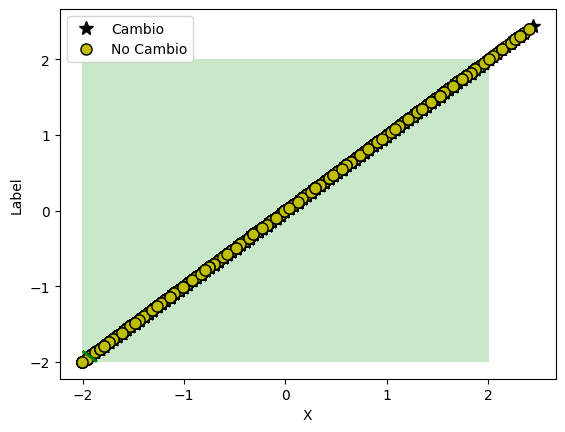

In [108]:
graficarLimiteDecision(graficarDatos, theta, X_train, y_train)

**(d) Optimizar los valores de theta con optimize.minimize.** Es una función de la biblioteca scipy que se utiliza para minimizar una función objetivo, en este caso, la función de costo. Puede utilizar varios métodos de optimización y es útil cuando se tienen funciones de costo complejas o cuando se desea utilizar algoritmos de optimización más avanzados que el descenso de gradiente simple.

In [109]:
options = {'maxiter': 1000}
res = optimize.minimize(funcionCosto, theta, args=(X_train, y_train), jac=True, method='L-BFGS-B', options=options)
cost = res.fun
theta = res.x

**(e) Realizar Predicciones.** Realizar predicciones es el propósito final de cualquier modelo de aprendizaje automático. Una vez que el modelo ha sido entrenado y optimizado, se utilizan las características de nuevos datos para predecir la salida. En la regresión logística, esto significa clasificar los datos en categorías basadas en la probabilidad calculada por el modelo. Las predicciones permiten aplicar el modelo a situaciones del mundo real y obtener información valiosa a partir de los datos.

In [112]:
predictions = predecir(theta, X_test)
accuracy = np.mean(predictions == y_test.values) * 100
print("Precisión de las nuevas predicciones en el conjunto de prueba: {:.2f}%".format(accuracy))

[0.24623989 0.23690491 0.25568267 ... 0.26080437 0.25371884 0.26305503]
Precisión de las nuevas predicciones en el conjunto de prueba: 75.38%
